<a href="https://colab.research.google.com/github/shaheer1995/Hyperspectral-Classification/blob/master/HSI_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the repository

In [1]:
!git clone "https://github.com/shaheer1995/Hyperspectral-Classification"

Cloning into 'Hyperspectral-Classification'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 71 (delta 24), reused 11 (delta 5), pack-reused 23
Unpacking objects: 100% (71/71), done.


Install requires Packages

In [2]:
!pip install spectral==0.19 
!pip install visdom==0.1.5

     |████████████████████████████████| 143kB 6.6MB/s 
  Created wheel for spectral: filename=spectral-0.19-cp36-none-any.whl size=180171 sha256=1808d4615ca4f0471b10da25eb1210b69759729ac0d3a7877065e22a023582d6
  Stored in directory: /root/.cache/pip/wheels/93/7e/15/a200ebb0b557d54eb396234737f9593ce705ed98a954bf148b
Successfully built spectral
  Created wheel for visdom: filename=visdom-0.1.5-cp36-none-any.whl size=28323 sha256=29c5ce9f3683903183704e3947bc7d78d9cafb9da9a36bb1fcfd1825ea69b7aa
  Stored in directory: /root/.cache/pip/wheels/00/58/4a/26e569ae188cf8ddb6e4187a50d3480ada478a5472020240ac
Successfully built visdom


In [3]:
%cd /content/Hyperspectral-Classification/ 

/content/Hyperspectral-Classification


Import Libraries

In [4]:
# Python 2/3 compatiblity
from __future__ import print_function
from __future__ import division

# Torch
import torch
import torch.utils.data as data
from torchsummary import summary

# Numpy, scipy, scikit-image, spectral
import numpy as np
import sklearn.svm
import sklearn.model_selection
from skimage import io
# Visualization
import seaborn as sns
import visdom

import os
from utils import metrics, convert_to_color_, convert_from_color_,\
    display_dataset, display_predictions, explore_spectrums, plot_spectrums,\
    sample_gt, build_dataset, show_results, compute_imf_weights, get_device
from datasets import get_dataset, HyperX, open_file, DATASETS_CONFIG
from models import get_model, train, test, save_model
import argparse

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [40]:
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
sns.axes_style('whitegrid');
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np

In [6]:
%mkdir Datasets

Set Parameters

In [21]:
# % of training samples
SAMPLE_PERCENTAGE = 0.3
# Dataset name
DATASET = 'IndianPines'
# Model name
MODEL = 'SVM'
# Target folder to store/download/load the datasets
FOLDER = '/content/Hyperspectral-Classification/Datasets/'
CUDA_DEVICE = 0
# # Number of runs (for cross-validation)
# N_RUNS = args.runs
# # Spatial context size (number of neighbours in each spatial direction)
# PATCH_SIZE = args.patch_size
# # Number of epochs to run
# EPOCH = args.epoch
# # Sampling mode, e.g random sampling
# SAMPLING_MODE = args.sampling_mode
# # Pre-computed weights to restore
# CHECKPOINT = args.restore
# # Learning rate for the SGD
# LEARNING_RATE = args.lr
TRAIN_GT = None
# Testing ground truth file
TEST_GT = None
TEST_STRIDE = 1
SAMPLING_MODE = 'random'
N_RUNS=1
CLASS_BALANCING = False

In [22]:
# Load the dataset
img, gt, LABEL_VALUES, IGNORED_LABELS, RGB_BANDS, palette = get_dataset(DATASET,FOLDER)

Visualize Random Bands

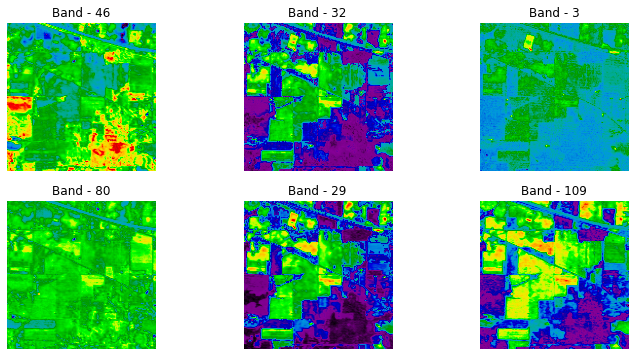

In [23]:
fig = plt.figure(figsize = (12, 6))

for i in range(1, 1+6):
    fig.add_subplot(2,3, i)
    q = np.random.randint(img.shape[2])
    plt.imshow(img[:,:,q], cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {q}')
plt.savefig('IP_Bands.png')

Show the ground Truth


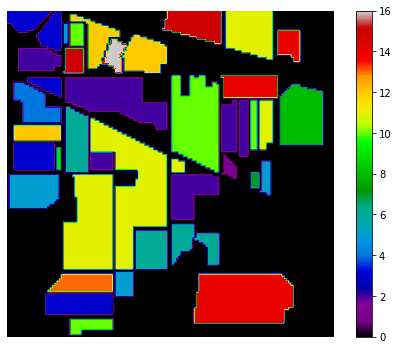

In [24]:
plt.figure(figsize=(8, 6))
plt.imshow(gt, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.savefig('IP_GT.png')
plt.show()

In [25]:
# Number of classes
# N_CLASSES = len(LABEL_VALUES) -  len(IGNORED_LABELS)
N_CLASSES = len(LABEL_VALUES)
# Number of bands (last dimension of the image tensor)
N_BANDS = img.shape[-1]

# Parameters for the SVM grid search
SVM_GRID_PARAMS = [{'kernel': ['rbf'], 'gamma': [1e-1, 1e-2, 1e-3],
                                       'C': [1, 10, 100, 1000]},
                   {'kernel': ['linear'], 'C': [0.1, 1, 10, 100, 1000]},
                   {'kernel': ['poly'], 'degree': [3], 'gamma': [1e-1, 1e-2, 1e-3]}]

if palette is None:
    # Generate color palette
    palette = {0: (0, 0, 0)}
    for k, color in enumerate(sns.color_palette("hls", len(LABEL_VALUES) - 1)):
        palette[k + 1] = tuple(np.asarray(255 * np.array(color), dtype='uint8'))
invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(x):
    return convert_to_color_(x, palette=palette)
def convert_from_color(x):
    return convert_from_color_(x, palette=invert_palette)

In [26]:
hyperparams = vars()
# Instantiate the experiment based on predefined networks
hyperparams.update({'n_classes': N_CLASSES, 'n_bands': N_BANDS, 'ignored_labels': IGNORED_LABELS, 'device': CUDA_DEVICE})
hyperparams = dict((k, v) for k, v in hyperparams.items() if v is not None)

In [27]:
import warnings
warnings.filterwarnings("ignore")

3074 samples selected (over 10249)


(-0.5, 144.5, 144.5, -0.5)

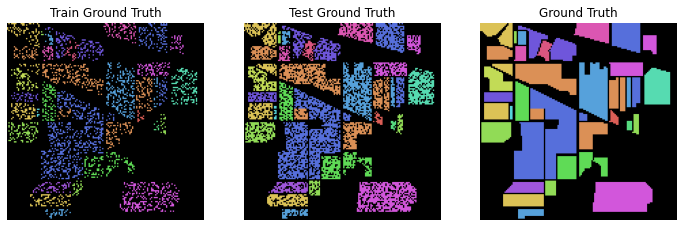

In [36]:
# Sample random training spectra
train_gt, test_gt = sample_gt(gt,SAMPLE_PERCENTAGE, mode=SAMPLING_MODE)
print("{} samples selected (over {})".format(np.count_nonzero(train_gt), np.count_nonzero(gt)))

fig = plt.figure(figsize = (12, 18))

fig.add_subplot(1,3,1)
plt.imshow(convert_to_color(train_gt), cmap='nipy_spectral')
plt.title('Train Ground Truth')
plt.axis('off')
fig.add_subplot(1,3,2)
plt.imshow(convert_to_color(test_gt), cmap='nipy_spectral')
plt.title('Test Ground Truth')
plt.axis('off')
fig.add_subplot(1,3,3)
plt.imshow(convert_to_color(gt), cmap='nipy_spectral')
plt.title('Ground Truth')
plt.axis('off')

In [35]:
print("Running an experiment with the {} model".format(MODEL))
results = []

if MODEL == 'SVM_grid':
    print("Running a grid search SVM")
    # Grid search SVM (linear and RBF)
    X_train, y_train = build_dataset(img, train_gt,
                                      ignored_labels=IGNORED_LABELS)
    class_weight = 'balanced' if CLASS_BALANCING else None
    clf = sklearn.svm.SVC(class_weight=class_weight)
    clf = sklearn.model_selection.GridSearchCV(clf, SVM_GRID_PARAMS, verbose=5, n_jobs=4)
    clf.fit(X_train, y_train)
    print("SVM best parameters : {}".format(clf.best_params_))
    prediction = clf.predict(img.reshape(-1, N_BANDS))
    save_model(clf, MODEL, DATASET)
    prediction = prediction.reshape(img.shape[:2])
elif MODEL == 'SVM':
    X_train, y_train = build_dataset(img, train_gt,
                                      ignored_labels=IGNORED_LABELS)
    class_weight = 'balanced' if CLASS_BALANCING else None
    clf = sklearn.svm.SVC(class_weight=class_weight)
    clf.fit(X_train, y_train)
    save_model(clf, MODEL, DATASET)
    prediction = clf.predict(img.reshape(-1, N_BANDS))
    prediction = prediction.reshape(img.shape[:2])
elif MODEL == 'SGD':
    X_train, y_train = build_dataset(img, train_gt,
                                      ignored_labels=IGNORED_LABELS)
    X_train, y_train = sklearn.utils.shuffle(X_train, y_train)
    scaler = sklearn.preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    class_weight = 'balanced' if CLASS_BALANCING else None
    clf = sklearn.linear_model.SGDClassifier(class_weight=class_weight, learning_rate='optimal', tol=1e-3, average=10)
    clf.fit(X_train, y_train)
    save_model(clf, MODEL, DATASET)
    prediction = clf.predict(scaler.transform(img.reshape(-1, N_BANDS)))
    prediction = prediction.reshape(img.shape[:2])
elif MODEL == 'nearest':
    X_train, y_train = build_dataset(img, train_gt,
                                      ignored_labels=IGNORED_LABELS)
    X_train, y_train = sklearn.utils.shuffle(X_train, y_train)
    class_weight = 'balanced' if CLASS_BALANCING else None
    clf = sklearn.neighbors.KNeighborsClassifier(weights='distance')
    clf = sklearn.model_selection.GridSearchCV(clf, {'n_neighbors': [1, 3, 5, 10, 20]}, verbose=5, n_jobs=4)
    clf.fit(X_train, y_train)
    clf.fit(X_train, y_train)
    save_model(clf, MODEL, DATASET)
    prediction = clf.predict(img.reshape(-1, N_BANDS))
    prediction = prediction.reshape(img.shape[:2])
else:
    if CLASS_BALANCING:
        weights = compute_imf_weights(train_gt, N_CLASSES, IGNORED_LABELS)
        hyperparams['weights'] = torch.from_numpy(weights)
    # Neural network
    model, optimizer, loss, hyperparams = get_model(MODEL, **hyperparams)
    # Split train set in train/val
    train_gt, val_gt = sample_gt(train_gt, 0.95, mode='random')
    # Generate the dataset
    train_dataset = HyperX(img, train_gt, **hyperparams)
    train_loader = data.DataLoader(train_dataset,
                                    batch_size=hyperparams['batch_size'],
                                    #pin_memory=hyperparams['device'],
                                    shuffle=True)
    val_dataset = HyperX(img, val_gt, **hyperparams)
    val_loader = data.DataLoader(val_dataset,
                                  #pin_memory=hyperparams['device'],
                                  batch_size=hyperparams['batch_size'])

    print(hyperparams)
    print("Network :")
    with torch.no_grad():
        for input, _ in train_loader:
            break
        #summary(model.to(hyperparams['device']), input.size()[1:], device=hyperparams['device'])
        summary(model.to(hyperparams['device']), input.size()[1:])

    if CHECKPOINT is not None:
        model.load_state_dict(torch.load(CHECKPOINT))

    try:
        train(model, optimizer, loss, train_loader, hyperparams['epoch'],
              scheduler=hyperparams['scheduler'], device=hyperparams['device'],
              supervision=hyperparams['supervision'], val_loader=val_loader,
              display=viz)
    except KeyboardInterrupt:
        # Allow the user to stop the training
        pass

    probabilities = test(model, img, hyperparams)
    prediction = np.argmax(probabilities, axis=-1)

run_results = metrics(prediction, test_gt, ignored_labels=hyperparams['ignored_labels'], n_classes=N_CLASSES)

mask = np.zeros(gt.shape, dtype='bool')
for l in IGNORED_LABELS:
    mask[gt == l] = True
prediction[mask] = 0

color_prediction = convert_to_color(prediction)
# display_predictions(B, viz, gt=convert_to_color(test_gt), caption="Prediction vs. test ground truth")

results.append(run_results)
# show_results(run_results, viz, label_values=LABEL_VALUES)

Running an experiment with the SVM model
Saving model params in run


(-0.5, 144.5, 144.5, -0.5)

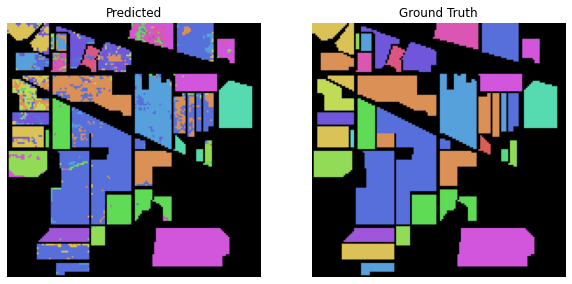

In [38]:
fig = plt.figure(figsize = (10, 16))

fig.add_subplot(1,2,1)
plt.imshow(color_prediction, cmap='nipy_spectral')
plt.title('Predicted')
plt.axis('off')
fig.add_subplot(1,2,2)
plt.imshow(convert_to_color(gt), cmap='nipy_spectral')
plt.title('Ground Truth')
plt.axis('off')

Overall Accuracy  :  79.60975609756098
Kappa  :  0.763881112252501


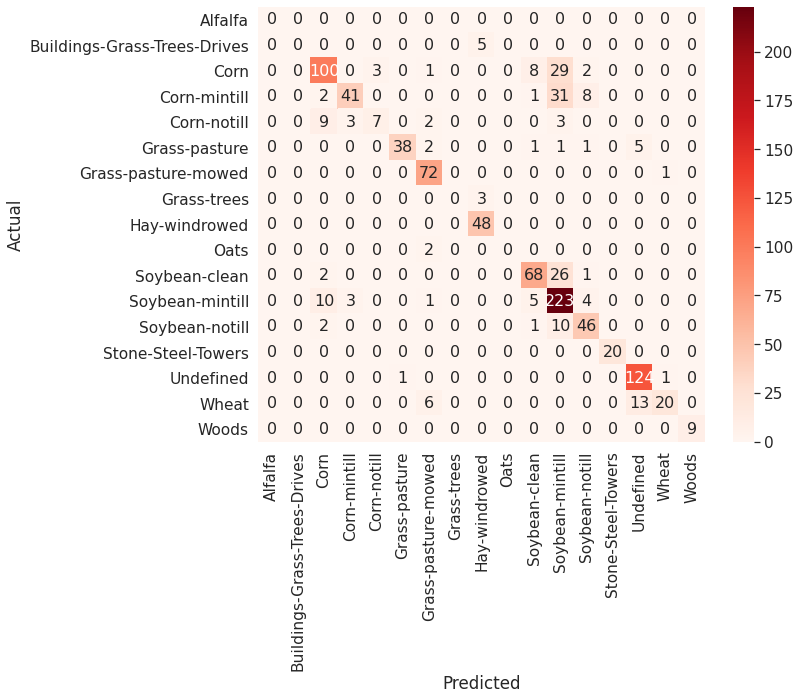

In [45]:
cm = run_results["Confusion matrix"]
df_cm = pd.DataFrame(cm, columns=np.unique(LABEL_VALUES), index = np.unique(LABEL_VALUES))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap.png', dpi=300)
accuracy = run_results["Accuracy"]
F1scores = run_results["F1 scores"]
kappa = run_results["Kappa"]
print("Overall Accuracy  :  " + str(accuracy))
print("Kappa  :  " + str(kappa))